# Import Libraries

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #, accuracy_score ,f1_score,confusion_matrix, classification_report
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

# Helper Functions

In [40]:
def remove_value(data, column_name, string_to_replace, replace_value='', change_dataType=True):
  data[column_name] = data[column_name].str.replace(string_to_replace, replace_value)
  if change_dataType:
    data[column_name] = data[column_name].astype(int)
    # data[column_name].value_counts()

In [41]:
def Feature_Encoder(X, cols):
    encoders = {}
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
        encoders[c] = lbl
    return X, encoders

In [42]:
# def featureScaling(X, a, b):
#     X = np.array(X)
#     Normalized_X = np.zeros((X.shape[0], X.shape[1]))
#     for i in range(X.shape[1]):
#         Normalized_X[:, i] = ((X[:, i] - min(X[:, i])) / (max(X[:, i]) - min(X[:, i]))) * (b - a) + a
#     return Normalized_X

In [43]:
def execute_model(model, X_train, Y_train, X_test, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(Y_train, Y_train_pred)
    print(f"{model_name}:\n Training MSE: {train_mse}")

    test_mse = mean_squared_error(Y_test, Y_test_pred)
    print(f" Testing MSE: {test_mse}")

    draw(Y_test, Y_test_pred, model_name)

In [44]:
def draw(Y_test, Y_test_pred, model_name):

    plt.figure
    plt.subplot(2,1,1)
    plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')

    plt.subplot(2,1,2)
    plt.scatter(range(len(Y_test_pred)), Y_test_pred, color='red', label=model_name)

    plt.xlabel('Data Points')
    plt.ylabel('Target Variable')
    plt.title('Regression Model Predictions')
    plt.legend()
    plt.show()

# Read Data

In [45]:
data = pd.read_csv('ElecDeviceRatingPrediction.csv')
# print(data.head())


In [46]:
# Calculate mode for each column
mode_values = data.mode()

mode_dict = {}

for col in mode_values.columns:
    mode_dict[col] = mode_values[col][0]

print(mode_dict)

{'brand': 'ASUS', 'processor_brand': 'Intel', 'processor_name': 'Core i5', 'processor_gnrtn': '11th', 'ram_gb': '8 GB', 'ram_type': 'DDR4', 'ssd': '512 GB', 'hdd': '0 GB', 'os': '64-bit Windows', 'graphic_card_gb': '0 GB', 'weight': 'Casual', 'warranty': '1 year', 'Touchscreen': 'No', 'msoffice': 'No', 'Price': 64990, 'rating': '4 stars', 'Number of Ratings': 0, 'Number of Reviews': 0}


# Preprocessing

## Null Values

In [47]:
print(data.isna().sum())

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64


## Features

In [48]:
# processor_gnrtn
data['processor_gnrtn'].value_counts()
mode_value = data['processor_gnrtn'].mode()[0]
data['processor_gnrtn'].replace('Not Available', mode_value, inplace = True)
remove_value(data, 'processor_gnrtn', 'th')

In [49]:
# ram_gb
remove_value(data,'ram_gb' ,' GB')

In [50]:
# ssd
remove_value(data,'ssd' ,' GB')

In [51]:
# hdd
remove_value(data,'hdd' ,' GB')

In [52]:
# os
data[['os_bits', 'os_type']] = data['os'].str.split(' ', expand=True)
data = data.drop('os', axis = 1)
print('os_bits', ":", data['os_bits'].unique())
print('os_type', ":", data['os_type'].unique())
remove_value(data,'os_bits' ,'-bit')


os_bits : ['64-bit' '32-bit']
os_type : ['Windows' 'DOS' 'Mac']


In [53]:
# graphic_card_gb
remove_value(data,'graphic_card_gb' ,' GB')

In [54]:
# warranty
remove_value(data,'warranty' ,'No warranty', '0', False)
remove_value(data,'warranty' ,' years', '', False)
remove_value(data,'warranty' ,' year')

In [55]:
# Touchscreen
remove_value(data,'Touchscreen' ,'No', '0', False)
remove_value(data,'Touchscreen' ,'Yes', '1')

In [56]:
# msoffice
remove_value(data,'msoffice' ,'No', '0', False)
remove_value(data,'msoffice' ,'Yes', '1')

In [57]:
# rating
remove_value(data,'rating' ,' stars', '', False)
remove_value(data,'rating' ,' star')

In [58]:
# ram_type
ram_performance_mapping = {
    'LPDDR4X': 5,
    'LPDDR4': 4,
    'DDR4': 3,
    'DDR3': 2,
    'DDR5': 6,
    'LPDDR3': 1
}

data['ram_type'] = data['ram_type'].map(ram_performance_mapping)
# data['ram_type'].value_counts()

In [59]:
# weight
weight = {
    'Casual':2,
    'ThinNlight':1,
    'Gaming':3,
}
data['weight'] = data['weight'].map(weight)

In [60]:
# brand , processor_name
encode_cols = ('brand', 'processor_name')
data, encoders = Feature_Encoder(data, encode_cols)

In [61]:
one_hot_encoders = {}

# processor_brand
one_hot_encoded = pd.get_dummies(data['processor_brand'])
one_hot_encoded = one_hot_encoded.astype(int)
data = data.drop('processor_brand', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

one_hot_encoders['processor_brand'] = one_hot_encoded

In [62]:
# os_type
one_hot_encoded = pd.get_dummies(data['os_type'])
one_hot_encoded = one_hot_encoded.astype(int)
data = data.drop('os_type', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

one_hot_encoders['os_type'] = one_hot_encoded

In [63]:
# Replace target column
rating_col = data['rating']
data = data.drop('rating', axis = 1)
data = pd.concat([data, rating_col], axis=1)

## Outliers

<Axes: >

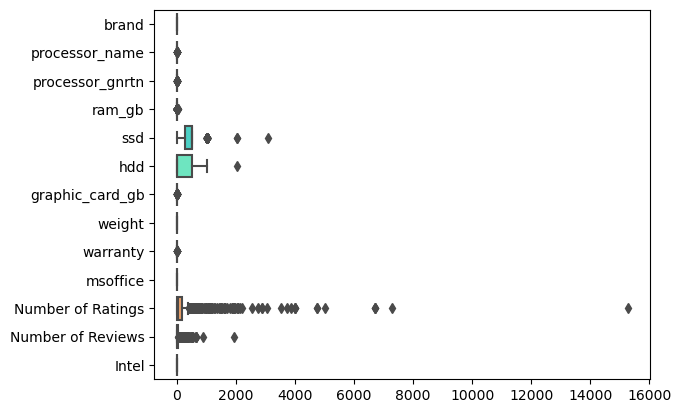

In [64]:
columns_to_exclude = ['ram_type', 'Touchscreen', 'os_bits', 'AMD', 'M1', 'DOS', 'Mac', 'Windows', 'rating','Price']
data_filtered = data.drop(columns=columns_to_exclude)
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

In [65]:
Q1 = data.iloc[:,:-1].quantile(0.25)
Q3 = data.iloc[:,:-1].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

s = ['ram_type' ,'Touchscreen', 'os_bits' , 'AMD' , 'M1' , 'DOS' , 'Mac' , 'Windows' ]

# Replace the outliers with lower_bound or upper_bound values
for col in data.iloc[:,:-1]:
    if col not in s:
        data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
        data.loc[data[col] > upper_bound[col], col] = upper_bound[col]

C:\Users\20115\AppData\Local\Temp\ipykernel_9400\1521850178.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
C:\Users\20115\AppData\Local\Temp\ipykernel_9400\1521850178.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
C:\Users\20115\AppData\Local\Temp\ipykernel_9400\1521850178.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[co

<Axes: >

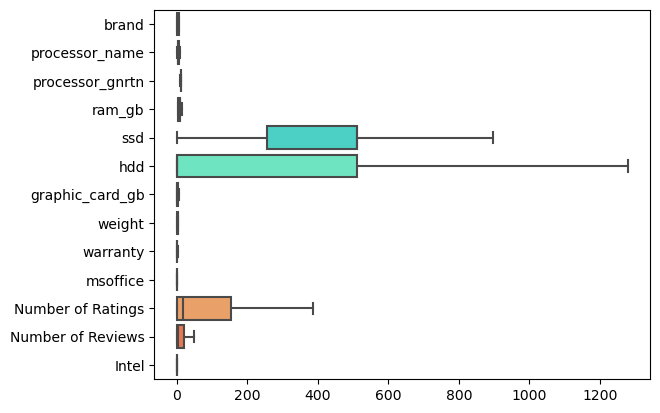

In [66]:
data_filtered = data.drop(columns=columns_to_exclude)
plt.figure()
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

## Feature selection

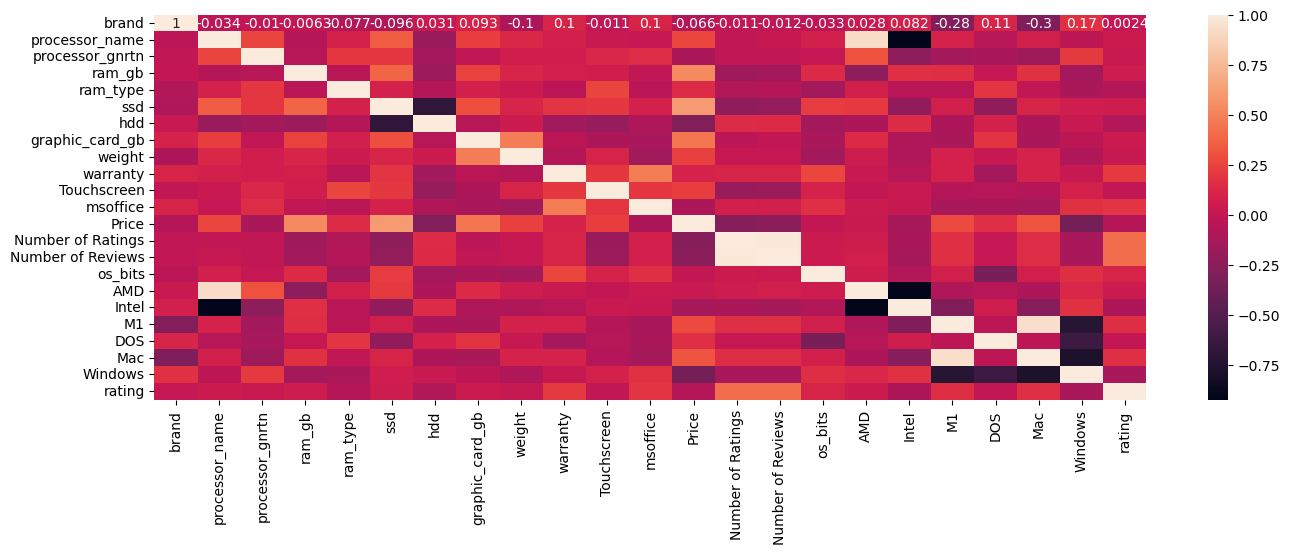

In [67]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [68]:
print(corr_matrix["rating"].sort_values(ascending=False))

rating               1.000000
Number of Reviews    0.411103
Number of Ratings    0.409994
warranty             0.203488
msoffice             0.185427
Mac                  0.160914
M1                   0.152030
os_bits              0.105672
ssd                  0.049794
ram_gb               0.048108
processor_name       0.044920
AMD                  0.042674
graphic_card_gb      0.035395
processor_gnrtn      0.023220
weight               0.018774
brand                0.002407
DOS                 -0.005155
Touchscreen         -0.011999
Price               -0.060844
ram_type            -0.068767
hdd                 -0.078448
Intel               -0.099465
Windows             -0.124356
Name: rating, dtype: float64


In [69]:
top_feature = corr_matrix.index[abs(corr_matrix['rating']) > 0.1]
print("Top features: ", top_feature)

Top features:  Index(['warranty', 'msoffice', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'M1', 'Mac', 'Windows', 'rating'],
      dtype='object')


In [70]:
print("Features after preprocessing:\n")
for col in data.columns:
  if(col == "Price" or col == "Number of Ratings" or col == "Number of Reviews"):
    continue
  print(col, ":", data[col].unique(), data[col].dtype)

Features after preprocessing:

brand : [1 5 4 0 3 7 6 2] int32
processor_name : [6.  2.  0.  1.  9.  5.  8.  3.  7.  9.5 4. ] float64
processor_gnrtn : [11.  10.   8.5 12.   9. ] float64
ram_gb : [ 4  8 14] int32
ram_type : [5 4 3 2 6 1] int64
ssd : [  0 256 512 896 128] int32
hdd : [ 512    0 1024 1280] int32
graphic_card_gb : [0 4 2 5] int32
weight : [2. 1. 3.] float64
warranty : [0.  1.  2.5 2. ] float64
Touchscreen : [0 1] int32
msoffice : [0. 1.] float64
os_bits : [64 32] int32
AMD : [0 1] int32
Intel : [1. 0.] float64
M1 : [0 1] int32
DOS : [0 1] int32
Mac : [0 1] int32
Windows : [1 0] int32
rating : [3 4 5 2 1] int32


# Regression Models

## Split Data

In [71]:
X = data.iloc[:, :-1]
Y = data['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

# plt.figure
# plt.subplot(2,1,1)
# plt.scatter(range(len(Y)), Y, color='blue', label='Actual')


## Linear Regression

Linear Regression:
 Training MSE: 0.24494941660875694
 Testing MSE: 0.20292934084576697


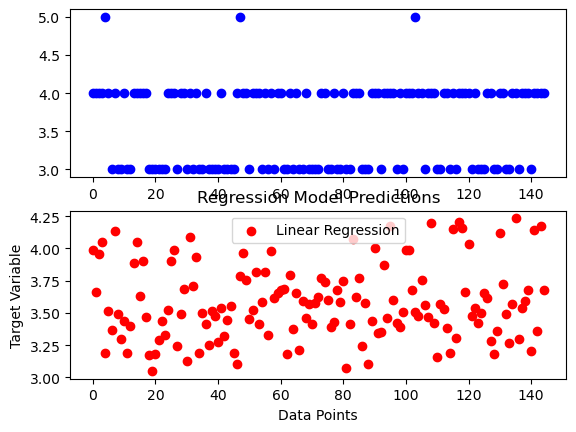

In [72]:
linear_regression_model = linear_model.LinearRegression()
execute_model(linear_regression_model, X_train, Y_train, X_test, Y_test, "Linear Regression")

## Polynomial Regression

Polynomial Regression:
 Training MSE: 0.1447368236020065
 Testing MSE: 0.3363671897090843


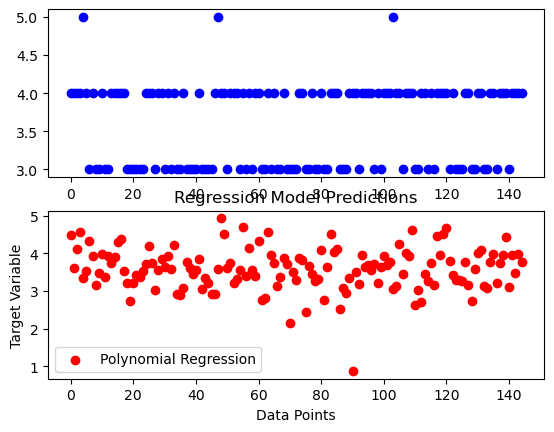

In [73]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

poly_model = linear_model.LinearRegression()
execute_model(poly_model, X_train_poly, Y_train, X_test_poly, Y_test, "Polynomial Regression")


## Decision Tree

Decision Tree:
 Training MSE: 0.0
 Testing MSE: 0.3310344827586207


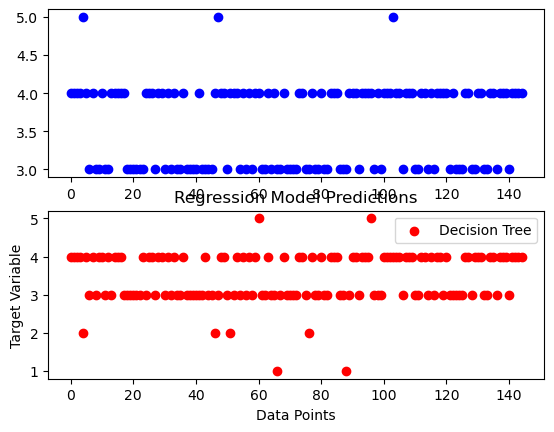

In [74]:
decision_tree_reg = DecisionTreeRegressor()
execute_model(decision_tree_reg, X_train, Y_train, X_test, Y_test, "Decision Tree")

In [75]:
print(data['Price'])

0       45990
1      106167
2       22990
3       44990
4       79990
        ...  
718     39998
719     44990
720     64990
721    155675
722     41990
Name: Price, Length: 723, dtype: int64


# Saving

In [76]:
import pickle
filename = 'MS1 test script regression.sav'
linear_regression_model.fit(X_train, Y_train)
pickle.dump(linear_regression_model, open(filename, 'wb'))